In [2]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import get_relevant_output_layers, compute_samples_sizes, load_npz_as_dict
from general_utils.static_dRSA import init_whole_neural_RDM, similarity_subsamples_par
from general_utils.plots import truncate_colormap, plot_subsamples

In [25]:
from dataclasses import dataclass, field

@dataclass
class Cfg:
    monkey_name: str = 'paul' 
    date: str = '230204'
    model_name: str = 'vit_l_16'
    layer_name: str = 'blocks.23.mlp.fc2'
    pkg: str = 'timm'
    img_size: int = 384
    brain_area: str = 'AIT'
    max_size: int = 2500
    n_trials: int = 4377
    step_samples: int = 100 # of how many samples we jump every time
    similarity_measure: str = 'cosine'
    pooling: str = 'mean'
    new_fs: int = 100 # Hz
    n_iter: int = 100 # how many time we repeat the sampling
    RDM_metric: str = 'cosine'
    RSA_metric: str = 'correlation'
cfg = Cfg()
layers = get_relevant_output_layers(cfg.model_name, cfg.pkg)
brain_areas = ['V1', 'V2', 'V3', 'PIT', 'CIT', 'AIT']

In [ ]:
plot_subsamples(paths, layers,cfg, ylim=[-.2, .6])

KeyboardInterrupt: 

In [4]:
file_name = (
    f"subsampling_{cfg.new_fs}Hz_{cfg.step_samples}-{cfg.max_size}_"
    f"{cfg.n_iter}iter_{cfg.monkey_name}_{cfg.date}_"
    f"{cfg.brain_area}_{cfg.model_name}_{cfg.img_size}_{cfg.layer_name}.npz"
)
file_path = f"{paths['livingstone_lab']}/tiziano/results/{file_name}"
iter_dict = load_npz_as_dict(file_path)

In [5]:
ground_truth = iter_dict[str(cfg.n_trials)]
print(ground_truth.shape)

(40,)


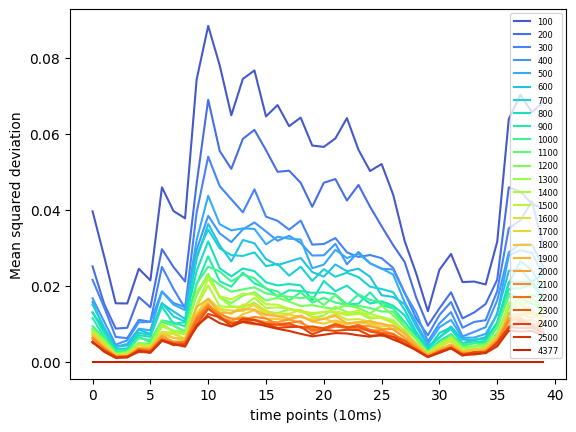

In [6]:
from matplotlib.colors import LinearSegmentedColormap
from general_utils.plots import truncate_colormap
base_cmap = plt.cm.turbo
cmap = truncate_colormap(base_cmap, 0.10, 0.90)

tot_keys_n = len(iter_dict.keys())
for idx, k in enumerate(iter_dict.keys()):
    color = cmap(idx / (tot_keys_n - 1))
    squared_deviation = np.square(iter_dict[k] - ground_truth)
    if k != "4377":
        mean_squared_deviation = np.mean(squared_deviation, axis=0)
    else:
        mean_squared_deviation = squared_deviation
    stdev = np.sqrt(mean_squared_deviation)
    plt.plot(stdev, color=color, label=k)
# plt.plot(np.mean(np.abs(iter_dict[str(100)] - ground_truth), axis=0))
plt.ylabel("Mean squared deviation")
plt.xlabel("time points (10ms) ")
plt.legend(fontsize=6)

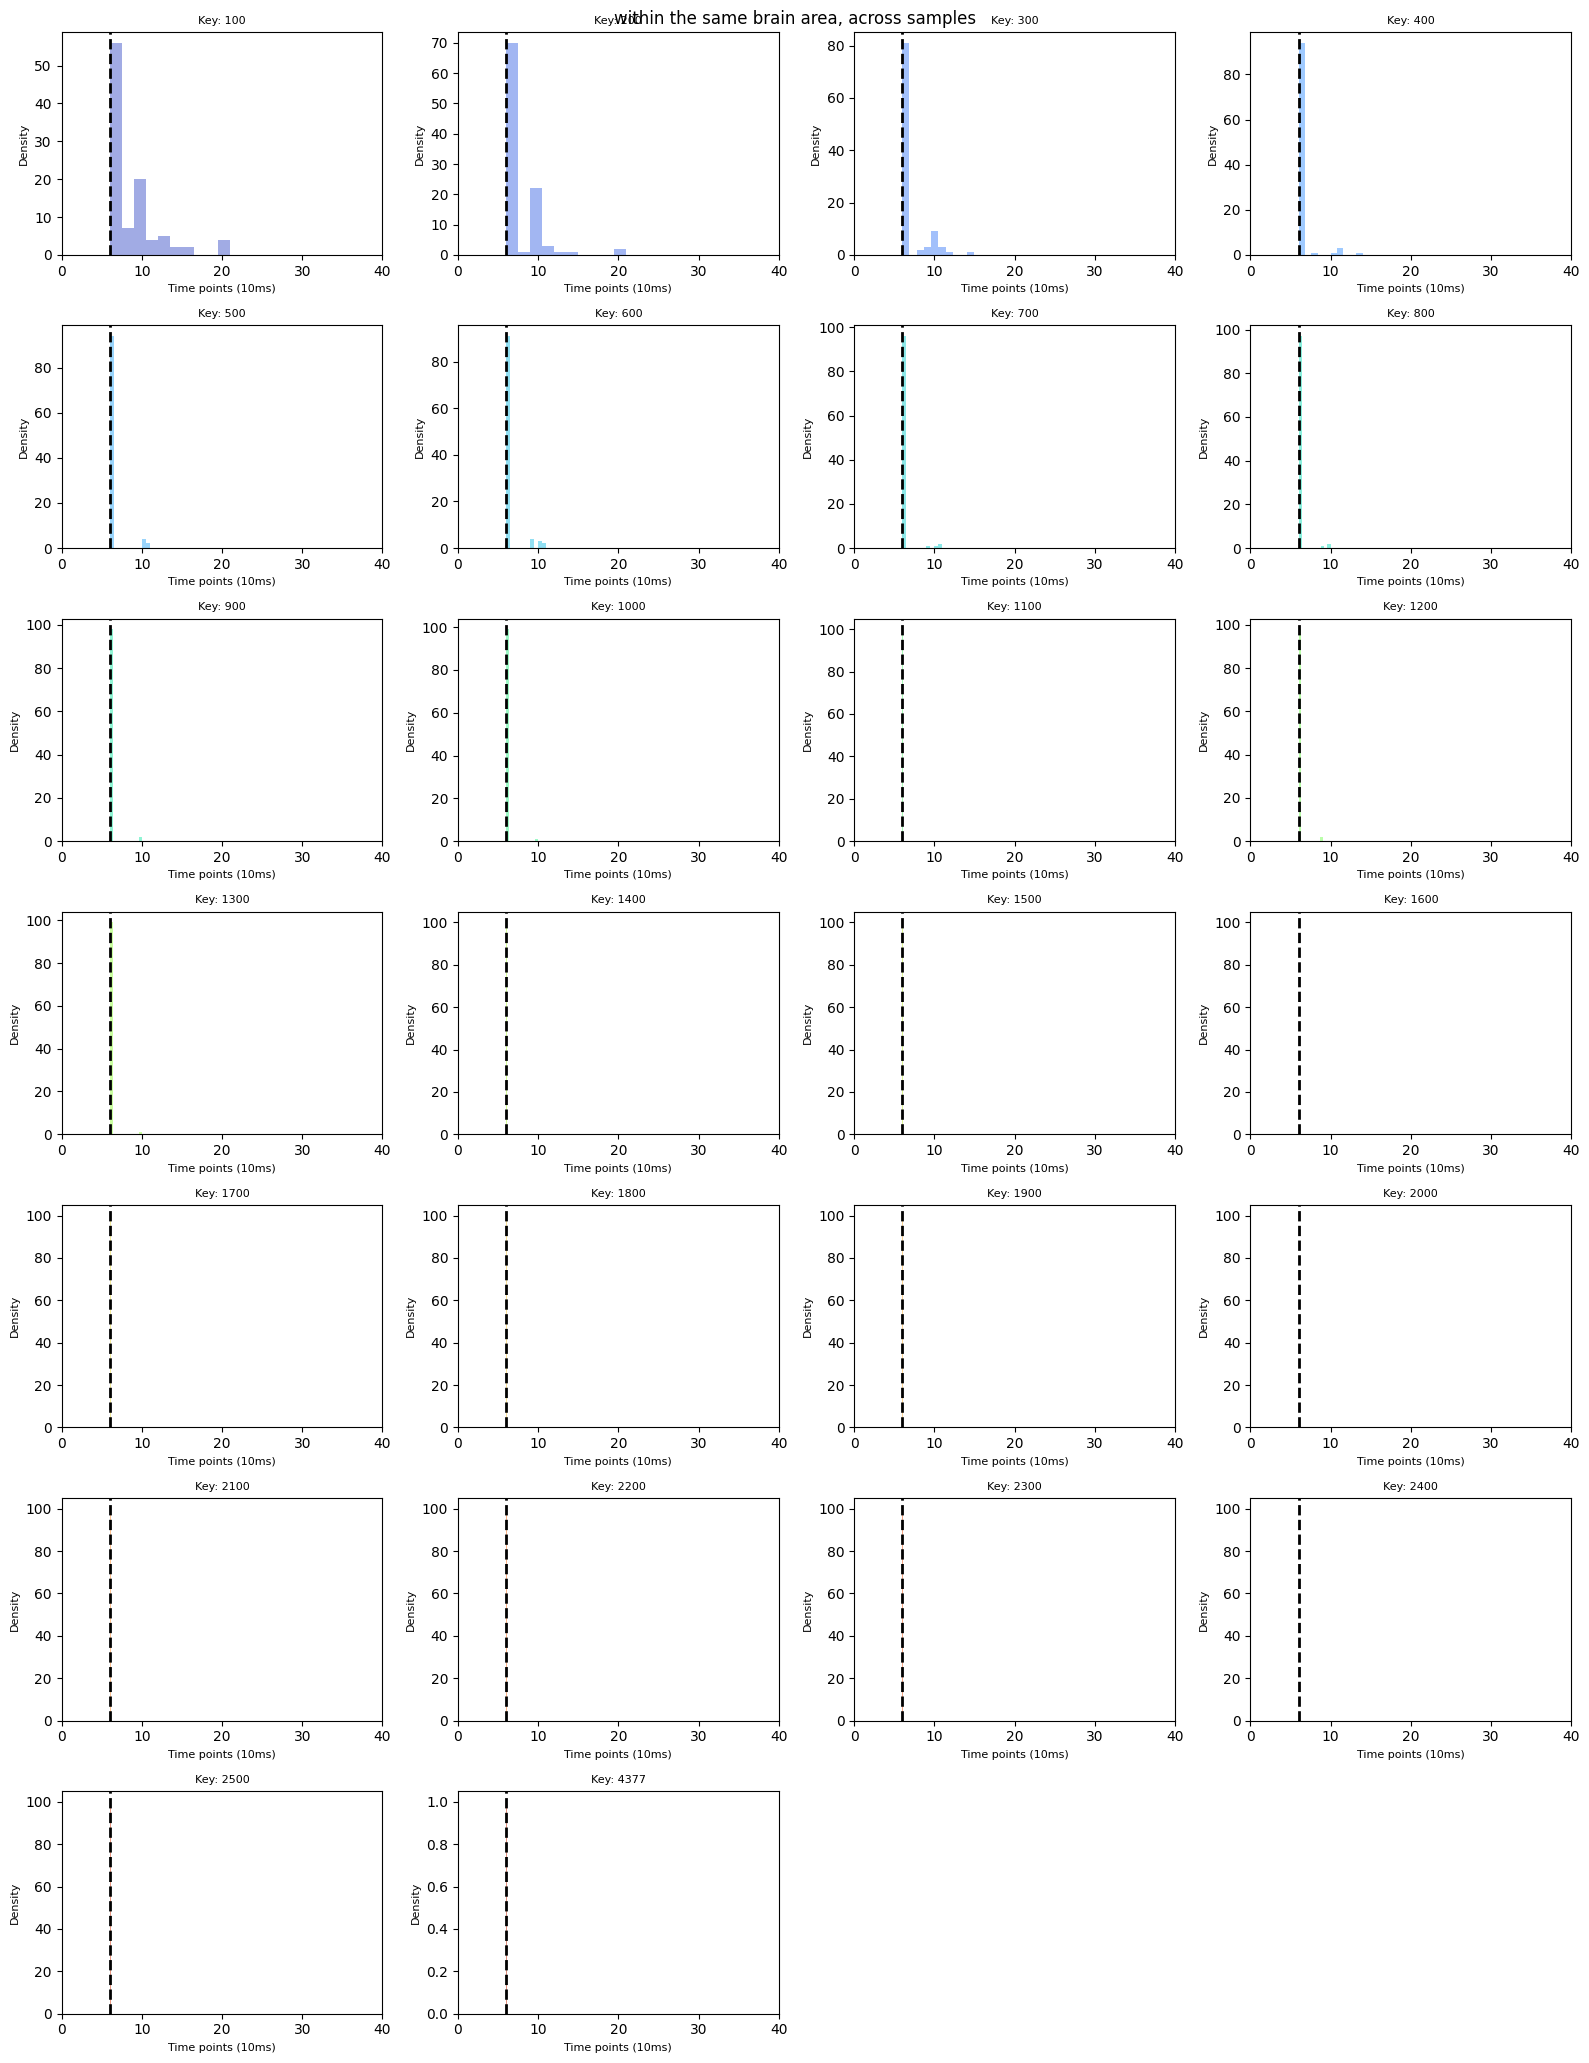

In [19]:
import matplotlib.pyplot as plt

keys = list(iter_dict.keys())
tot_keys_n = len(keys)

# Determine grid size for subplots (e.g., square-ish layout)
n_cols = 4
n_rows = (tot_keys_n + n_cols - 1) // n_cols  # ceil division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axes = axes.flatten()  # flatten to easily index
gt_latency = np.argmax(iter_dict[k])
for idx, k in enumerate(keys):
    ax = axes[idx]
    color = cmap(idx / (tot_keys_n - 1))
    
    if k != "4377":
        peak_latencies = np.argmax(iter_dict[k][:,:30], axis=1)
    else:
        peak_latencies = np.argmax(iter_dict[k])
    
    ax.hist(peak_latencies, alpha=0.5, color=color, density=False)
    ax.axvline(x=gt_latency, color='k', linestyle='--', linewidth=2)
    ax.set_title(f"Key: {k}", fontsize=8)

    ax.set_xlabel("Time points (10ms)", fontsize=8)
    ax.set_ylabel("Density", fontsize=8)
    ax.set_xlim(0, 40)

fig.suptitle("within the same brain area, across samples")
# Turn off unused subplots (if any)
for i in range(tot_keys_n, len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

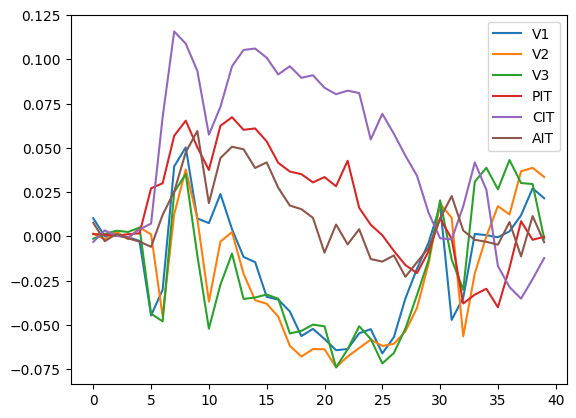

In [34]:
cfg.layer_name = 'blocks.20.mlp.fc2'
lat_list = []
for idx, ba in enumerate(brain_areas):
    file_name = (
        f"subsampling_{cfg.new_fs}Hz_{cfg.step_samples}-{cfg.max_size}_"
        f"{cfg.n_iter}iter_{cfg.monkey_name}_{cfg.date}_"
        f"{ba}_{cfg.model_name}_{cfg.img_size}_{cfg.layer_name}.npz"
    )
    file_path = f"{paths['livingstone_lab']}/tiziano/results/{file_name}"
    iter_dict_ba = load_npz_as_dict(file_path)
    curr_gt = iter_dict_ba[k]
    plt.plot(curr_gt, label=ba)
    # lat_list.append(curr_gt)
# plt.bar(brain_areas,lat_list)
plt.legend()

In [ ]:
import matplotlib.pyplot as plt

keys = list(iter_dict.keys())
tot_keys_n = len(keys)

# Determine grid size for subplots (e.g., square-ish layout)
n_cols = 4
n_rows = (tot_keys_n + n_cols - 1) // n_cols  # ceil division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axes = axes.flatten()  # flatten to easily index
gt_latency = np.argmax(iter_dict[k])
for idx, ba in enumerate(brain_areas):
    file_name = (
        f"subsampling_{cfg.new_fs}Hz_{cfg.step_samples}-{cfg.max_size}_"
        f"{cfg.n_iter}iter_{cfg.monkey_name}_{cfg.date}_"
        f"{ba}_{cfg.model_name}_{cfg.img_size}_{cfg.layer_name}.npz"
    )
    file_path = f"{paths['livingstone_lab']}/tiziano/results/{file_name}"
    iter_dict_ba = load_npz_as_dict(file_path)
    ax = axes[idx]
    color = cmap(idx / (tot_keys_n - 1))
    
    # if k != "4377":
    #     peak_latencies = np.argmax(iter_dict[k][:,:30], axis=1)
    # else:
    #     peak_latencies = np.argmax(iter_dict[k])
    
    ax.hist(peak_latencies, alpha=0.5, color=color, density=False)
    ax.axvline(x=gt_latency, color='k', linestyle='--', linewidth=2)
    ax.set_title(f"Key: {k}", fontsize=8)

    ax.set_xlabel("Time points (10ms)", fontsize=8)
    ax.set_ylabel("Density", fontsize=8)
    ax.set_xlim(0, 40)

fig.suptitle("within the same brain area, across samples")
# Turn off unused subplots (if any)
for i in range(tot_keys_n, len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()